In [1]:
"*ein: http://127.0.0.1:8899/make_figs.ipynb*"
(defun switch-to-notebook ()
 (interactive)
 (st-toggle-to-buffer "*ein: http://127.0.0.1:8899/make_figs.ipynb*<2>"))

SyntaxError: invalid syntax (<ipython-input-1-63a19210c978>, line 2)

In [129]:
%pylab inline
import os,sys
import pickle
from importlib import reload
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
from matplotlib.gridspec import GridSpec
from scipy.signal import stft

Populating the interactive namespace from numpy and matplotlib


In [130]:
PLOT = True # Whether to actually make the plots

In [242]:
import boulder;                         reload(boulder)
import crick;                           reload(crick)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
FisherPlumes = fp.FisherPlumes

force_reload = True
if force_reload or ('Fbw' not in locals()):
    pairs_mode = "unsigned"
    #Fbw = FisherPlumes("boulder16", which_coords = [(0.45, 0.5)], py_mode = "relative", suffix = 'wideDomain.old',pairs_mode = pairs_mode, n_bootstraps = 50, random_seed = 0)
    Fcr = FisherPlumes("n12dishT",  which_coords = [(1.0, 0.5)], pairs_mode = pairs_mode, n_bootstraps = 50, random_seed = 0)
else:
    #Fbw = FisherPlumes(Fbw)
    Fcr = FisherPlumes(Fcr)
    
data = {
    "cr":Fcr,
    "bw":Fbw
}

INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_wideDomain.old.h5     : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:ff_int_sym_slow_high_tres_wide_n12dishT         : Y0.450 - Y0.550 (11 datasets)


           fisher_plumes 2022/10/12 16:22:42     INFO: ****** LOADING sim_name='n12dishT' ******


     fisher_plumes_tools 2022/10/12 16:22:42     INFO: load_sims for sim_name='n12dishT' with which_coords=[(1.0, 0.5)] (py_mode='absolute').


     fisher_plumes_tools 2022/10/12 16:22:42     INFO: Using absolute py coordinates.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.500


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.520


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.505


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-0.5 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.502


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-0.2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.450


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=5 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.490


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=1 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.498


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=0.2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.480


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=2 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.510


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-1 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.495


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=0.5 cm.


INFO:crick:Loaded ff_int_sym_slow_high_tres_wide_n12dishT_Y0.550


INFO:crick:Mapped coordinate ( 1.000,  0.500) to ( 0.999,  0.500), index 852, name x=59.9 cm, y=-5 cm.


     fisher_plumes_tools 2022/10/12 16:22:52     INFO: Yvals: [450000, 480000, 490000, 495000, 498000, 500000, 502000, 505000, 510000, 520000, 550000]


     fisher_plumes_tools 2022/10/12 16:22:52     INFO: Computing distance pairings.


     fisher_plumes_tools 2022/10/12 16:22:52     INFO: Computing pairs for len(yvals)=11 from 450000 to 550000 using pairs_mode='unsigned'.


     fisher_plumes_tools 2022/10/12 16:22:52     INFO: Removing duplicates in pairs dictionary.


     fisher_plumes_tools 2022/10/12 16:22:52     INFO: 24 distance pairings found, from 0 to 100000


In [237]:
Fcr.sim0.save_snapshot(40)

INFO:crick:Snapshoting S1 for y=450.0 at t=40.


INFO:crick:Reading field from png_file='/camp/lab/schaefera/working/tootoos/git/crick-cfd/projects/distance-discrimination/simulations/cylgrid/ff_int_sym_slow_high_tres_wide/n12dishT/proc/Y0.450/Y0.450.png/S1_d0_040001.png'.


INFO:crick:Wrote data for S1 at y=450 t=40 to data/y450_S1_t40.p


In [240]:
res = Fcr.sim0.load_saved_snapshot(40)

INFO:crick:Loading fld='S1' at t=40 from full_file='./y450.0_S1_t40.p'.


FileNotFoundError: [Errno 2] No such file or directory: './y450.0_S1_t40.p'

In [231]:
res.shape

(846, 1001)

In [219]:
Fbw.sims.keys()

dict_keys([7500, -7500, 22500, -22500, 37500, -37500, 52500, -52500, 67500, -67500, 82500, -82500, 97500, -97500, 112500, -112500])

In [220]:
Fcr.sim0.get_key()

450000

# Compute all the statistics

In [170]:
wnd_sec = 1.
dmax    = 40000
wnd = {k:int(F.fs*wnd_sec) for k, F in data.items()}
istart = {k:0 if k[0] == "b" else 1000 for k, F in data.items()} 
[(print(k, end = ""), sys.stdout.flush(), F.compute_all_for_window(wnd = wnd[k],
                                                                   istart = istart[k],
                                                                   window = 'boxcar',
                                                                   tukey_param = 0,
                                                                   dmax = dmax if k != "bw" else 2*dmax,
                                                                   fit_amps = False,                                                                  
)) for k, F in data.items()];

cr

           fisher_plumes 2022/10/12 15:11:23     INFO: Window set to self.wnd=1000.


           fisher_plumes 2022/10/12 15:11:23     INFO: Computing trig coefficients for n12dishT with istart=1000 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2022/10/12 15:11:24     INFO: Computing amplitude of generalized gaussian fits to λ(s).


           fisher_plumes 2022/10/12 15:11:25     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2022/10/12 15:11:36     INFO: Computing lambdas.


           fisher_plumes 2022/10/12 15:11:36     INFO: Creating pooling functions.


           fisher_plumes 2022/10/12 15:12:10     INFO: Computing p-values.


           fisher_plumes 2022/10/12 15:12:10     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2022/10/12 15:12:26     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2022/10/12 15:12:26     INFO: Using 16 distances <= 40000


           fisher_plumes 2022/10/12 15:12:26     INFO: Computed λ for 501 frequencies and 16 distances and 51 bootstraps.


           fisher_plumes 2022/10/12 15:12:26     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2022/10/12 15:12:51    DEBUG: self.fit_params.shape=(51, 501, 2).


bw

/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py:194: RuntimeWarning: divide by zero encountered in power
  return (k/γ)**2 * (sn ** (k - 1))**2/(np.exp(sn ** k) - 1)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py:194: RuntimeWarning: divide by zero encountered in true_divide
  return (k/γ)**2 * (sn ** (k - 1))**2/(np.exp(sn ** k) - 1)
/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py:194: RuntimeWarning: invalid value encountered in true_divide
  return (k/γ)**2 * (sn ** (k - 1))**2/(np.exp(sn ** k) - 1)
           fisher_plumes 2022/10/12 15:12:51     INFO: Window set to self.wnd=50.


           fisher_plumes 2022/10/12 15:12:51     INFO: Computing trig coefficients for boulder16 with istart=0 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2022/10/12 15:12:51     INFO: Computing amplitude of generalized gaussian fits to λ(s).


           fisher_plumes 2022/10/12 15:12:51     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2022/10/12 15:12:52     INFO: Computing lambdas.


           fisher_plumes 2022/10/12 15:12:52     INFO: Creating pooling functions.


           fisher_plumes 2022/10/12 15:12:53     INFO: Computing p-values.


           fisher_plumes 2022/10/12 15:12:53     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2022/10/12 15:12:54     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2022/10/12 15:12:54     INFO: Using 6 distances <= 80000


           fisher_plumes 2022/10/12 15:12:54     INFO: Computed λ for 26 frequencies and 6 distances and 51 bootstraps.


           fisher_plumes 2022/10/12 15:12:54     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2022/10/12 15:12:57    DEBUG: self.fit_params.shape=(51, 26, 2).


# Figure showing an example plume and correlations

In [144]:
logging.getLogger("boulder").setLevel(logging.DEBUG)

In [191]:
Fcr.sim0.source

[0.4, 0.45]

In [195]:
Fbw.sim0.fields

['Odor Data/c8b']

In [203]:
Fbw.sim0.source

array([[ 0.    ,  0.0075],
       [ 0.    , -0.0075],
       [ 0.    ,  0.0225],
       [ 0.    , -0.0225],
       [ 0.    ,  0.0375],
       [ 0.    , -0.0375],
       [ 0.    ,  0.0525],
       [ 0.    , -0.0525],
       [ 0.    ,  0.0675],
       [ 0.    , -0.0675],
       [ 0.    ,  0.0825],
       [ 0.    , -0.0825],
       [ 0.    ,  0.0975],
       [ 0.    , -0.0975],
       [ 0.    ,  0.1125],
       [ 0.    , -0.1125]])

In [194]:
Fcr.sim0.fields


['S1']

In [173]:
t_snapshot = 40;
boulder_fields = {(i,ab): load_field(f"c{i}{ab}", t_snapshot) for i in range(1,9) for ab in "ab"};
crick_fields   = {yval: load_field("S1", t_snapshot, name=yval) for yval in Fcr.yvals//1000}

Loading fld='c1a' at t=40 for name=None from full_file='./data/c1a_t40.p'.
Loading fld='c1b' at t=40 for name=None from full_file='./data/c1b_t40.p'.
Loading fld='c2a' at t=40 for name=None from full_file='./data/c2a_t40.p'.
Loading fld='c2b' at t=40 for name=None from full_file='./data/c2b_t40.p'.
Loading fld='c3a' at t=40 for name=None from full_file='./data/c3a_t40.p'.
Loading fld='c3b' at t=40 for name=None from full_file='./data/c3b_t40.p'.
Loading fld='c4a' at t=40 for name=None from full_file='./data/c4a_t40.p'.


Loading fld='c4b' at t=40 for name=None from full_file='./data/c4b_t40.p'.
Loading fld='c5a' at t=40 for name=None from full_file='./data/c5a_t40.p'.
Loading fld='c5b' at t=40 for name=None from full_file='./data/c5b_t40.p'.
Loading fld='c6a' at t=40 for name=None from full_file='./data/c6a_t40.p'.
Loading fld='c6b' at t=40 for name=None from full_file='./data/c6b_t40.p'.


Loading fld='c7a' at t=40 for name=None from full_file='./data/c7a_t40.p'.
Loading fld='c7b' at t=40 for name=None from full_file='./data/c7b_t40.p'.
Loading fld='c8a' at t=40 for name=None from full_file='./data/c8a_t40.p'.
Loading fld='c8b' at t=40 for name=None from full_file='./data/c8b_t40.p'.
Loading fld='S1' at t=40 for name=450 from full_file='./data/y450_S1_t40.p'.
Loading fld='S1' at t=40 for name=480 from full_file='./data/y480_S1_t40.p'.


Loading fld='S1' at t=40 for name=490 from full_file='./data/y490_S1_t40.p'.
Loading fld='S1' at t=40 for name=495 from full_file='./data/y495_S1_t40.p'.
Loading fld='S1' at t=40 for name=498 from full_file='./data/y498_S1_t40.p'.
Loading fld='S1' at t=40 for name=500 from full_file='./data/y500_S1_t40.p'.
Loading fld='S1' at t=40 for name=502 from full_file='./data/y502_S1_t40.p'.
Loading fld='S1' at t=40 for name=505 from full_file='./data/y505_S1_t40.p'.
Loading fld='S1' at t=40 for name=510 from full_file='./data/y510_S1_t40.p'.
Loading fld='S1' at t=40 for name=520 from full_file='./data/y520_S1_t40.p'.
Loading fld='S1' at t=40 for name=550 from full_file='./data/y550_S1_t40.p'.


2000
5000
10000


Wrote figs/plumes_demo_cr.pdf.


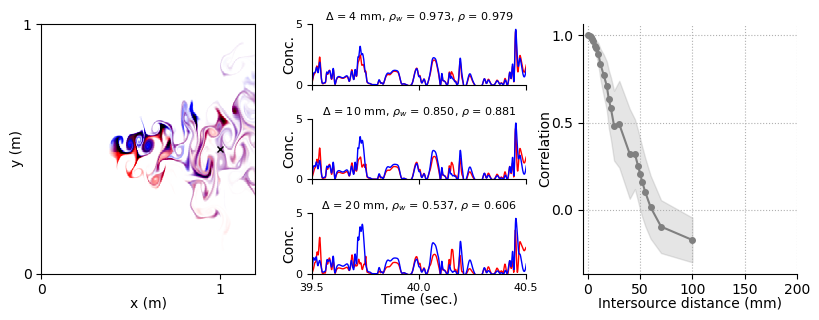

In [190]:
import boulder
reload(fpft)
name = 'cr'
F = data[name]
wnd = F.wnd

figure(figsize=(8,3))
gs = GridSpec(3,3)
ax_plume = subplot(gs[:,0])
dx, dy = F.sim0.dimensions
if name == 'bw':
    pp = boulder.concs2rgb(boulder_fields[1,"a"], boulder_fields[1,"b"])
    ax_plume.matshow(pp, extent = [0, dx, -dy/2, dy/2])
else:
    pp = boulder.concs2rgb(crick_fields[490], crick_fields[510])
    ax_plume.matshow(pp, extent = [0, dx, 0, dy])
px, py = F.sim0.get_used_probe_coords()[0]
ax_plume.plot(px, py, "kx", markersize=5)
ax_plume.xaxis.set_ticks_position('bottom')
ax_plume.axis("auto")
xlabel("x (m)", labelpad=-1)
ylabel("y (m)", labelpad=-1)
#ax_plume.set_yticks(arange(-0.2,0.21,0.1) if 'wide' in name else arange(-0.1,0.11,0.1))

dists = np.array(sorted(F.sims.keys()))
middle = mean(dists)
dists = dists[dists>middle]
which_idists = [0,1,2]
tlim = np.array([-4,4] if name == "bw" else [-0.5, 0.5]) + t_snapshot
ysc  = 100 if name == "bw" else 1./2500
yl   = (0,10) if name == "bw" else (0,5)
ax_trace = []
for i, di in enumerate(which_idists):
    ax_trace.append(subplot(gs[i,1]))
    d_mid = int(dists[di] - middle)
    print(d_mid)
    a = F.sims[middle + d_mid].data.flatten()*ysc
    b = F.sims[middle - d_mid].data.flatten()*ysc
    t = F.sim0.t
    ax_trace[-1].plot(t,a,color="r", label=f"{middle + d_mid}", linewidth=1)
    ax_trace[-1].plot(t,b,color="b", label=f"{middle - d_mid}", linewidth=1)
    (i < 2) and ax_trace[-1].set_xticklabels([])
    (i ==2) and ax_trace[-1].set_xlabel("Time (sec.)", labelpad=-1)
    fpft.spines_off(ax_trace[-1])
    ax_trace[-1].set_xlim(*tlim)
    ax_trace[-1].set_xticks(arange(tlim[0],tlim[-1]+0.01,1 if name == "bw" else 0.5))
    ax_trace[-1].set_ylim(*yl)
    ax_trace[-1].set_yticks(arange(0,max(yl)+1,5))
    ax_trace[-1].tick_params(axis='both', labelsize=8)
    ax_trace[-1].set_ylabel("Conc.", labelpad=-1)
    #ax_trace[-1].legend(frameon=False,labelspacing=0,fontsize=6)
    wndf = lambda x: x[(t>=tlim[0])*(t<tlim[-1])]
    aw, bw = wndf(a), wndf(b)
    ρ_w = corrcoef(aw,bw)[0,1]
    ρ   = corrcoef(a, b)[0,1]
    # text(tlim[0], yl[1], f"$\Delta$ = {2*dists[di]/1000:g} mm\n$\\rho$ = {ρ_w:1.3f} (window)\n$\\rho$ = {ρ:1.3f} (all)", fontsize=6, verticalalignment="top")
    title(f"$\Delta$ = {2*d_mid/1000:g} mm, $\\rho_w$ = {ρ_w:1.3f}, $\\rho$ = {ρ:1.3f}", fontsize=8, verticalalignment="top")
#break    
    
ax_corr_dist = subplot(gs[:,-1])
rho   = F.rho
dists = np.array(sorted(list(rho.keys()))) 
rho   = {d:rho[d][0] for d in dists} # Take the raw data, not the bootstraps
rhom  = np.array([np.mean(np.sum(rho[d],axis=0)) for d in dists])
rhos  = np.array([ np.std(np.sum(rho[d],axis=0)) for d in dists])
col   = "gray"
plt.fill_between(dists/1000, rhom-rhos,rhom+rhos, color=fpft.set_alpha(mpl.colors.to_rgba(col),0.2));
fpft.pplot(dists/1000, rhom , "o-", markersize=4,color=col);
ax_corr_dist.set_xticks(arange(0,201 if name=='bw' else 101,50))
ax_corr_dist.grid(True, linestyle=":")
ax_corr_dist.set_yticks(arange(-1 if name == 'bw' else 0,1.1,0.5))
#ax_corr_dist.set_yticklabels(["-1","","0","","1"])
ax_corr_dist.set_ylabel("Correlation",labelpad=-1)
ax_corr_dist.set_xlabel("Intersource distance (mm)", labelpad=-1)
tight_layout(pad=0,w_pad=0,h_pad=1)
file_name = f"figs/plumes_demo_{name}.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

In [154]:
Fcr.pairs

{0: [(495000, 495000),
  (480000, 480000),
  (520000, 520000),
  (505000, 505000),
  (490000, 490000),
  (502000, 502000),
  (550000, 550000),
  (498000, 498000),
  (500000, 500000),
  (510000, 510000),
  (450000, 450000)],
 30000: [(520000, 490000),
  (550000, 520000),
  (510000, 480000),
  (480000, 450000)],
 -30000: [(480000, 510000),
  (520000, 550000),
  (450000, 480000),
  (490000, 520000)],
 40000: [(520000, 480000), (490000, 450000), (550000, 510000)],
 -40000: [(480000, 520000), (450000, 490000), (510000, 550000)],
 45000: [(550000, 505000), (495000, 450000)],
 -45000: [(505000, 550000), (450000, 495000)],
 48000: [(498000, 450000), (550000, 502000)],
 -48000: [(502000, 550000), (450000, 498000)],
 50000: [(550000, 500000), (500000, 450000)],
 -50000: [(450000, 500000), (500000, 550000)],
 52000: [(550000, 498000), (502000, 450000)],
 -52000: [(498000, 550000), (450000, 502000)],
 55000: [(550000, 495000), (505000, 450000)],
 -55000: [(450000, 505000), (495000, 550000)],
 6000

In [128]:
F.sim0

AttributeError: 'CrickSimulationData' object has no attribute 'x'

# Figure showing the distribution of correlations

Wrote figs/corr_components_bw.pdf.


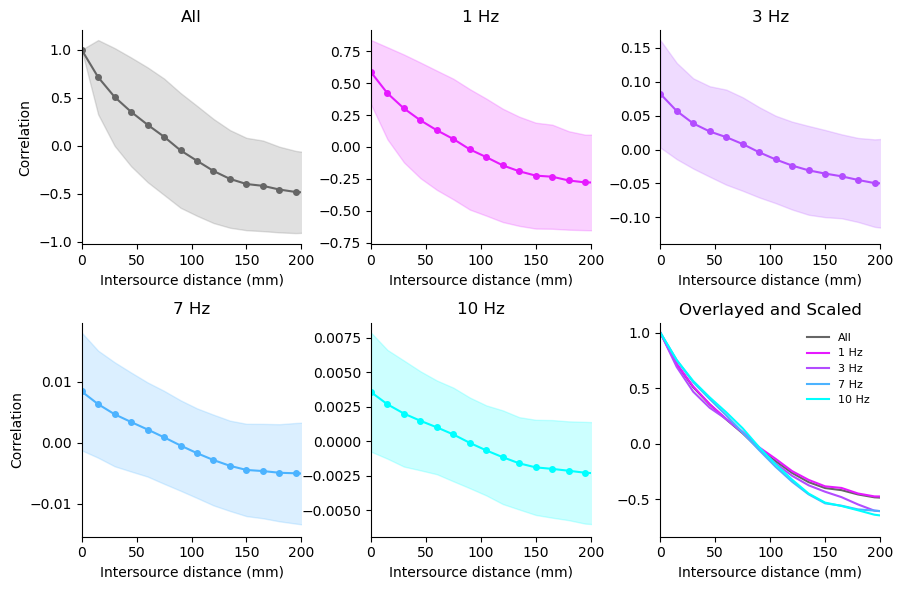

In [119]:
reload(fpf)
which_freqs = [1,3,7,10]
labs = [f"{f} Hz" for f in which_freqs]
cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f/10) for f in which_freqs])})
slices = {}
for k, F in data.items():
    if k in ["bw"]:
        slices[k] = {"All":slice(1,10000)}
        slices[k].update({l:slice(fi, fi+1) for l, fi in zip(labs, F.freqs2inds(which_freqs))})
        ax = fpf.plot_correlations(F.rho, xl = (0, 120), slices=slices[k], cols=cols, n_rows = 2, plot_order = ["All"] + labs)
        [(axi.set_xlabel("Intersource distance (mm)"), axi.set_xticks(arange(0,201,50))) for axi in ax]
        file_name = f"figs/corr_components_{k}.pdf"
        PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."))

# The Multivariate Gaussian Fits

Wrote figs/coef_vs_coef_bw.pdf.


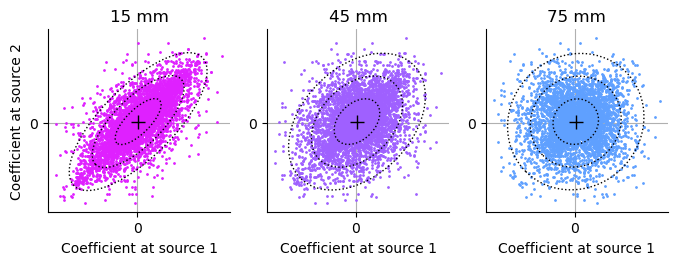

In [120]:
reload(fpf)
which_freq = 5
name = "bw"
F = data[name]
ifreq = F.freqs2inds([which_freq])[0]
fpf.plot_coef1_vs_coef2([F.ss, F.cc],
                        ifreq,
                        F.pairs)
file_name = f"figs/coef_vs_coef_{name}.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Asymmetric Laplacian Fits

d=15000 @ Freq #  10: -np.log10(p) = 31.977
d=30000 @ Freq #  10: -np.log10(p) = 18.155
d=45000 @ Freq #  10: -np.log10(p) = 9.682


/camp/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:175: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(-np.log10(p), #+np.min(p[p>0])/10),


Wrote figs/alap_fits_bw.pdf.


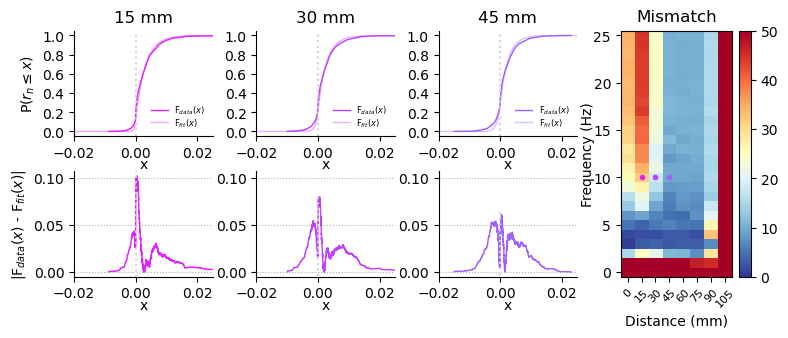

In [121]:
reload(fpf)
d = np.array(list(F.rho.keys()))
d = np.sort(d[d>0])
fpf.plot_alaplace_fits(F, d[:3],
                       ifreq_lim = [],
                       xl = [-0.02,0.025],
                       which_ifreq = 10,
                       figsize=(8,3.5), vmax=50,
                       cm_heat = cm.RdYlBu_r,
                       plot_dvals=True)
file_name = f"figs/alap_fits_{name}.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the figure showing λ(s)

Wrote figs/la_vs_s_fits_bw.pdf.


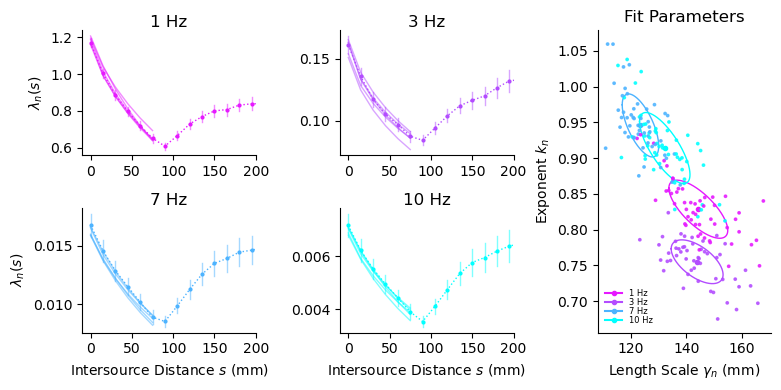

In [142]:
reload(fpft)
reload(fpf)
ax = fpf.plot_la_gen_fits_vs_distance(Fbw, 
                                      xl = (-10,200), figsize=(8,4), legloc = 'right',
                                      which_ifreqs = [1,3,7,10])
[(axi.set_xticks(arange(0,201,50)), (i>1) and axi.set_xlabel("Intersource Distance $s$ (mm)")) for i, axi in enumerate(ax[:4])]
tight_layout(h_pad=1,w_pad=0.5)
file_name = f"figs/la_vs_s_fits_{name}.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the Fisher information

Wrote figs/fisher_info_bw.pdf.


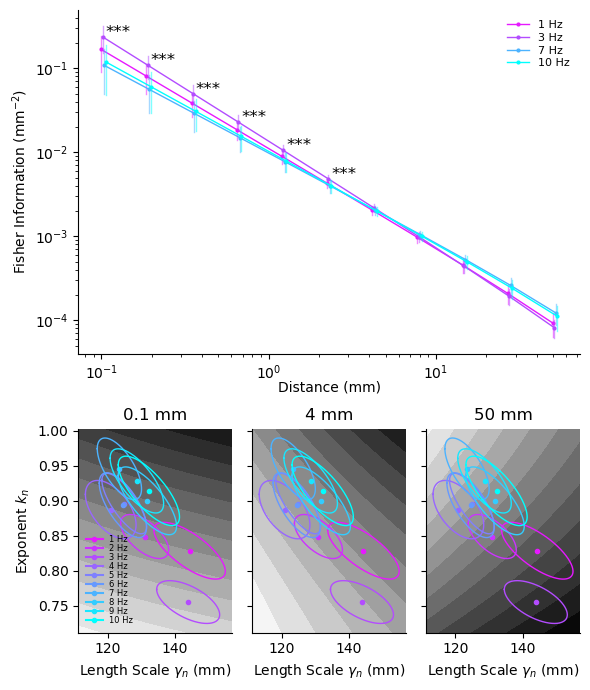

In [148]:
reload(fpf)
figure(figsize=(6,7))
fpf.plot_fisher_information(Fbw,                           
                            d_lim=[1,10000],
                            d_range = [100,50000],
                            d_scale = 1000,
                            d_vals = np.array([0.1,4,50])*1000,
                            d_space_fun = lambda d0,d1,n:np.logspace(log10(d0),log10(d1),n),
                            which_ifreqs = [1,3,7,10],
                            x_stagger = lambda x, i: x*(1.02**i),
                            fi_scale = 1, plot_fun = plt.loglog,
)
tight_layout(h_pad=1)
file_name = f"figs/fisher_info_{name}.pdf"
PLOT and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

In [124]:
! cp figs/*.pdf ../git/crick-fisher/ms/figs

cp: target ‘../git/crick-fisher/ms/figs’ is not a directory


In [128]:
! ls ../

ls: cannot access ../ms: No such file or directory
